# **Face Mask Detection using Deep Learning**

## **Introduction**
Face mask detection is a crucial application of deep learning and computer vision, especially in public health and safety. In this notebook, we implement a model to detect whether a person is wearing a mask or not using a Convolutional Neural Network (CNN) trained on labeled images.

## **Objectives**
- Build a deep learning model to classify masked and unmasked faces.
- Utilize OpenCV’s deep learning module for face detection.
- Apply the trained model to static images and pre-recorded videos.
- Save the trained model for future use.

## **Dataset**
We use a dataset containing images of individuals:
- **With Mask** 🟩
- **Without Mask** 🟥  

The dataset is preprocessed to ensure balanced representation and optimal model performance.

## **Workflow**
1. **Data Preprocessing**  
   - Load and augment image data.  
   - Convert images to numerical arrays and normalize pixel values.  
   - Split into training and validation sets.  

2. **Model Training**  
   - Train a CNN-based model or leverage a pre-trained network (e.g., MobileNetV2).  
   - Use appropriate loss functions and optimizers.  

3. **Evaluation & Model Saving**  
   - Assess performance using accuracy and loss metrics.  
   - Save the trained model to avoid re-training in future runs.  

4. **Face Mask Detection in Images & Videos**  
   - Use OpenCV’s DNN face detector to locate faces.  
   - Apply the trained model to classify mask usage.  
   - Display results with bounding boxes and labels.  

## **Implementation**
We implement the project using:
- **TensorFlow/Keras**: For model training and inference.
- **OpenCV**: For face detection.
- **Matplotlib**: For visualizing results.

## **Model Performance**
- **test_loss**:  0.054265428334474564
- **test_accuracy**:  0.979345977306366
- **Memory consumption** : 0 bytes
## **Using the Saved Model**
Once trained, the model is saved as a `.keras` file. To reuse it:
```python
from tensorflow.keras.models import load_model
model = load_model("mask_detector.keras")


In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, Xception, VGG16, InceptionV3
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Dropout, \
                                    Flatten, Dense, BatchNormalization, \
                                    SpatialDropout2D, AveragePooling2D, Input

import os
import cv2 
import warnings
import argparse
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

tf.get_logger().setLevel('WARNING')
#removed cnn and xception 
parser = argparse.ArgumentParser()
parser.add_argument('-d', '--data-dir', type=str, default='/kaggle/input/face-mask-dataset/data',
                    help="Directory of dataset")
parser.add_argument('-e', '--epochs', type=int, default=30,
                    help="Where to write the new data")
parser.add_argument("-m", "--model", type=str, default="mask_detector.keras",
                    help="Path to output face mask detector model")
parser.add_argument('-s', '--size', type=int, default=64,
                    help="Size of input data")
parser.add_argument('-b', '--batch-size', type=int, default=32,
                    help="Bactch size of data generator")
parser.add_argument('-l', '--learning-rate', type=float, default=0.0001,
                    help="Learning rate value")
parser.add_argument('-sh', '--show-history', action='store_true',
                    help="Show training history")
parser.add_argument('-n', '--net-type', type=str, default='MobileNetV2',
                    choices=[ 'CNN','MobileNetV2', 'VGG16','Xception'],
                    help="The network architecture, optional: MobileNetV2, VGG16")

_StoreAction(option_strings=['-n', '--net-type'], dest='net_type', nargs=None, const=None, default='MobileNetV2', type=<class 'str'>, choices=['CNN', 'MobileNetV2', 'VGG16', 'Xception'], required=False, help='The network architecture, optional: MobileNetV2, VGG16', metavar=None)

In [2]:

def CNN_model(learning_rate, input_shape):
    # Build model
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=input_shape, activation='relu'))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss="binary_crossentropy", metrics=["accuracy"], \
                  optimizer=Adam(learning_rate=learning_rate))
    return model


In [3]:


def MobileNetV2_model(learning_rate, input_shape):
    baseModel = MobileNetV2(include_top=False, input_tensor=Input(shape=input_shape))
    for layer in baseModel.layers[:-4]:
        layer.trainable = False

    model = Sequential()
    model.add(baseModel)
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # compile our model
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], \
                  optimizer=Adam(learning_rate=learning_rate))
    return model

In [4]:


def VGG16_model(learning_rate, input_shape):
    baseModel = VGG16(include_top=False, input_tensor=Input(shape=input_shape))
    for layer in baseModel.layers:
        layer.trainable = False

    model = Sequential()
    model.add(baseModel)
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # compile our model
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], \
                  optimizer=Adam(learning_rate=learning_rate))
    return model

In [5]:


def Xception_model(learning_rate, input_shape):
    baseModel = Xception(include_top=False, input_tensor=Input(shape=input_shape))
    for layer in baseModel.layers:
        layer.trainable = False

    model = Sequential()
    model.add(baseModel)
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # compile our model
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], \
                  optimizer=Adam(learning_rate=learning_rate))
    return model

In [6]:
def keras_model_memory_usage_in_bytes(model, batch_size):
    default_dtype = tf.keras.backend.floatx()
    total_memory = 0
    for layer in model.layers:
        # Skip layers that do not have an output_shape attribute
        if not hasattr(layer, 'output_shape'):
            continue

        # If the layer is a nested model, calculate its memory recursively.
        if isinstance(layer, tf.keras.Model):
            total_memory += keras_model_memory_usage_in_bytes(layer, batch_size=batch_size)
            continue

        # Get the size (in bytes) of one element of the layer's dtype.
        single_layer_mem = tf.as_dtype(layer.dtype or default_dtype).size

        out_shape = layer.output_shape
        if isinstance(out_shape, list):
            # Use the first output shape if the layer has multiple outputs.
            out_shape = out_shape[0]
        
        # Calculate total number of elements in the output shape,
        # replacing None dimensions (typically the batch size) with the actual batch_size.
        total_elements = 1
        for dim in out_shape:
            if dim is None:
                total_elements *= batch_size
            else:
                total_elements *= dim

        total_memory += single_layer_mem * total_elements

    return total_memory

In [7]:
if __name__ == "__main__":

    args, unknown = parser.parse_known_args()

    bs = args.batch_size
    lr = args.learning_rate
    size = (args.size, args.size)
    shape = (args.size, args.size, 3)
    epochs = args.epochs

    # Load and preprocess data
    train_dir = os.path.join(args.data_dir)
    test_dir = os.path.join(args.data_dir)
    valid_dir = os.path.join(args.data_dir)

    train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=5, zoom_range=0.2, \
                                       shear_range=0.2, brightness_range=[0.9, 1.1], \
                                       horizontal_flip=True)                  
    valid_datagen = ImageDataGenerator(rescale=1./255, rotation_range=5, zoom_range=0.2, \
                                       shear_range=0.2, brightness_range=[0.9, 1.1], \
                                       horizontal_flip=True)
    test_datagen  = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(train_dir, target_size=size, shuffle=True,
                                                        batch_size=bs, class_mode='binary')
    valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=size, shuffle=True,
                                                        batch_size=bs, class_mode='binary')
    test_generator  = test_datagen.flow_from_directory(test_dir, target_size=size, shuffle=True,
                                                        batch_size=bs, class_mode='binary')

    print(train_generator.class_indices)
    print(train_generator.image_shape)

Found 7553 images belonging to 2 classes.
Found 7553 images belonging to 2 classes.
Found 7553 images belonging to 2 classes.
{'with_mask': 0, 'without_mask': 1}
(64, 64, 3)


In [8]:
 # Build model
net_type_to_model = {
        'CNN' : CNN_model,
        'MobileNetV2': MobileNetV2_model,
        'VGG16' : VGG16_model,
        'Xception' : Xception_model
    }
model_name = args.net_type
model_builder = net_type_to_model.get(model_name)
model = model_builder(lr, shape)
model.summary()

<ipython-input-3-aef4201b6e1e>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(include_top=False, input_tensor=Input(shape=input_shape))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 2, 2, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 1, 1, 1280)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │          25,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,939,557 (11.21 MB)

 Trainable params: 1,094,373 (4.17 MB)

 Non-trainable params: 1,845,184 (7.04 MB)

In [9]:

earlystop = EarlyStopping(monitor='val_loss', patience=5, mode='auto')

tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

checkpoint = ModelCheckpoint(os.path.join("results", f"{model_name}" + f"-size-{size[0]}" + \
                                             f"-bs-{bs}" + f"-lr-{lr}.keras"),
                             monitor='val_loss', save_best_only=True, verbose=1)
# Train model
history = model.fit(train_generator, epochs=epochs, validation_data=valid_generator,
                    batch_size=bs, callbacks=[earlystop, tensorboard, checkpoint], shuffle=True)
test_loss, test_accuracy = model.evaluate(test_generator)   
metrics = pd.DataFrame(history.history)
print(metrics.head(10))

print('test_loss: ', test_loss)
print('test_accuracy: ', test_accuracy)
print('Memory consumption: %s bytes' % keras_model_memory_usage_in_bytes(model, batch_size=bs))

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  5/237 ━━━━━━━━━━━━━━━━━━━━ 1:04 278ms/step - accuracy: 0.5266 - loss: 1.1352

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.6933 - loss: 0.6259

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 0.27492, saving model to results/MobileNetV2-size-64-bs-32-lr-0.0001.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 123s 483ms/step - accuracy: 0.6937 - loss: 0.6253 - val_accuracy: 0.8819 - val_loss: 0.2749
Epoch 2/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8808 - loss: 0.2870
Epoch 2: val_loss improved from 0.27492 to 0.21088, saving model to results/MobileNetV2-size-64-bs-32-lr-0.0001.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 74s 311ms/step - accuracy: 0.8808 - loss: 0.2870 - val_accuracy: 0.9154 - val_loss: 0.2109
Epoch 3/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9032 - loss: 0.2372
Epoch 3: val_loss improved from 0.21088 to 0.16784, saving model to results/MobileNetV2-size-64-bs-32-lr-0.0001.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 73s 304ms/step - accuracy: 0.9032 - loss: 0.2372 - val_accuracy: 0.9342 - val_loss: 0.1678
Epoch 4/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9174 - loss: 0.1951
Epoch 4: val_loss improv

In [10]:
test_loss, test_accuracy = model.evaluate(test_generator)   
metrics = pd.DataFrame(history.history)
print(metrics.head(10))

print('test_loss: ', test_loss)
print('test_accuracy: ', test_accuracy)
print('Memory consumption: %s bytes' % keras_model_memory_usage_in_bytes(model, batch_size=bs))
    

 27/237 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - accuracy: 0.9826 - loss: 0.0422

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


237/237 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.9863 - loss: 0.0382
   accuracy      loss  val_accuracy  val_loss
0  0.776115  0.468765      0.881901  0.274918
1  0.886800  0.272506      0.915398  0.210880
2  0.906792  0.232657      0.934198  0.167838
3  0.916192  0.196332      0.942672  0.147812
4  0.927578  0.193482      0.948365  0.136146
5  0.932610  0.164381      0.952337  0.119442
6  0.936052  0.167399      0.959089  0.110980
7  0.940553  0.158755      0.963855  0.104418
8  0.947571  0.139481      0.966503  0.096081
9  0.949821  0.139446      0.968754  0.092899
test_loss:  0.03795628994703293
test_accuracy:  0.9862306118011475
Memory consumption: 0 bytes


In [11]:
print(args.model)

mask_detector.keras


In [12]:
# serialize the model to disk
print("saving mask detector model...")
#must add .keras or .h5 when you input the the save file path
args, unknown = parser.parse_known_args()
args.model = "mask_detector.keras"  # Manually override to ensure the correct extension.
model.save(args.model)


if args.show_history:
        plt.subplot(211)
        plt.title('Loss')
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()

        plt.subplot(212)
        plt.title('Accuracy')
        plt.plot(history.history['accuracy'], label='train')
        plt.plot(history.history['val_accuracy'], label='test')
        plt.legend()
        plt.show()

saving mask detector model...


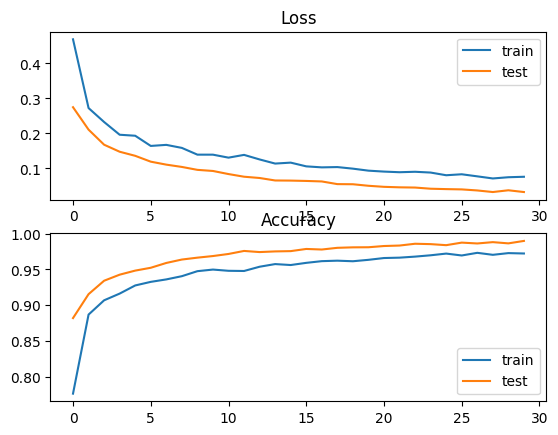

In [13]:
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [14]:
 !mkdir -p face_detector
 !wget -O face_detector/deploy.prototxt https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
 !wget -O face_detector/res10_300x300_ssd_iter_140000.caffemodel https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
parser.add_argument("-fd", "--faced", type=str, default="/kaggle/input/face-detector",
                    help="Path to face detector model directory")


--2025-03-23 13:50:29--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘face_detector/deploy.prototxt’

face_detector/deplo 100%[===================>]  27.45K  --.-KB/s    in 0s      

2025-03-23 13:50:29 (53.9 MB/s) - ‘face_detector/deploy.prototxt’ saved [28104/28104]

--2025-03-23 13:50:29--  https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/

_StoreAction(option_strings=['-fd', '--faced'], dest='faced', nargs=None, const=None, default='/kaggle/input/face-detector', type=<class 'str'>, choices=None, required=False, help='Path to face detector model directory', metavar=None)

Loading face detector from: /kaggle/working/face_detector/deploy.prototxt /kaggle/working/face_detector/res10_300x300_ssd_iter_140000.caffemodel
Loading mask detector model from: /kaggle/working/mask_detector.keras
Image shape: (1724, 2592, 3)
Blob shape: (1, 3, 300, 300)
Number of detections: 200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Detection 0: Mask with confidence 0.99
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Detection 1: Mask with confidence 0.96
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Detection 2: Mask with confidence 0.91
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Detection 3: Mask with confidence 0.87
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Detection 4: Mask with confidence 0.83
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Detection 5: No Mask with confidence 0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Detection 6: Mask with confidence 0.55


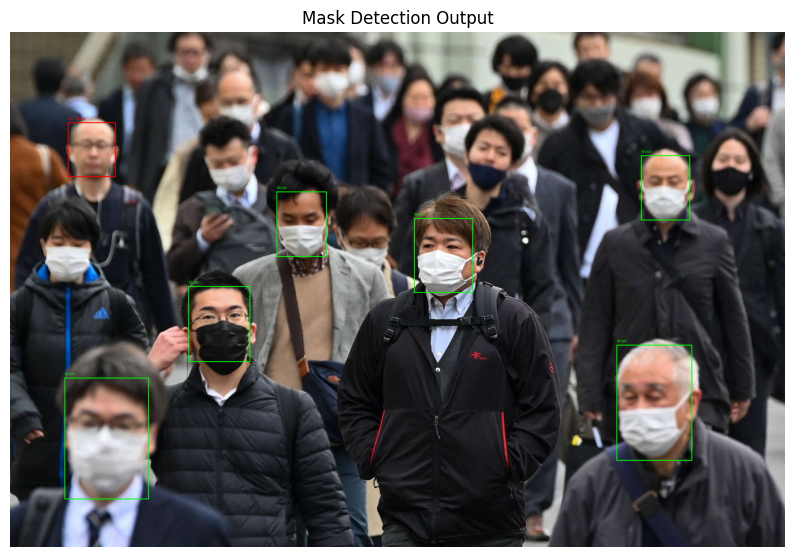

In [15]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input  # type: ignore
from tensorflow.keras.preprocessing.image import img_to_array  # type: ignore
from tensorflow.keras.models import load_model  # type: ignore
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Set paths and parameters
image_path = "/kaggle/input/multiple-mask-nomask-test/masks-tokyo-gty-ps-230314_1678802239571_hpMain.jpg"
face_detector_path = "/kaggle/working/face_detector"  
model_path = "/kaggle/working/mask_detector.keras"       
size = 64
confidence_threshold = 0.55  # You may lower this if needed

def mask_image(image_path, face_detector_path, model_path, size, confidence_threshold):
    # Load the face detector model files
    prototxtPath = os.path.sep.join([face_detector_path, "deploy.prototxt"])
    weightsPath = os.path.sep.join([face_detector_path, "res10_300x300_ssd_iter_140000.caffemodel"])
    print("Loading face detector from:", prototxtPath, weightsPath)
    
    try:
        net = cv2.dnn.readNetFromCaffe(prototxtPath, weightsPath)
    except Exception as e:
        print("Error loading face detector:", e)
        return

    # Load the mask detector model
    print("Loading mask detector model from:", model_path)
    try:
        model = load_model(model_path)
    except Exception as e:
        print("Error loading mask detector model:", e)
        return

    # Read the input image
    image = cv2.imread(image_path)
    if image is None:
        print("Cannot read file:", image_path)
        return
    print("Image shape:", image.shape)

    # If the image is smaller than 300x300, resize it so the face detector works correctly
    if image.shape[0] < 300 or image.shape[1] < 300:
        print("Image too small, resizing to 300x300")
        image = cv2.resize(image, (300, 300))

    # Create blob with fixed size of 300x300 (expected by the face detector)
    blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(300, 300), mean=(104.0, 177.0, 123.0))
    print("Blob shape:", blob.shape)

    net.setInput(blob)
    detections = net.forward()
    num_detections = detections.shape[2]
    print("Number of detections:", num_detections)

    found_face = False

    for i in range(0, num_detections):
        conf = detections[0, 0, i, 2]
        if conf < confidence_threshold:
            continue

        box = detections[0, 0, i, 3:7] * np.array([image.shape[1], image.shape[0],
                                                     image.shape[1], image.shape[0]])
        (startX, startY, endX, endY) = box.astype("int")
        startX, startY = max(0, startX), max(0, startY)
        endX, endY = min(image.shape[1] - 1, endX), min(image.shape[0] - 1, endY)

        # Extract the face region and check if it's valid
        face_region = image[startY:endY, startX:endX]
        if face_region.size == 0:
            print("Empty face region detected; skipping detection", i)
            continue

        try:
            found_face = True
            face = cv2.cvtColor(face_region, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (size, size))
            face = img_to_array(face)
            face = preprocess_input(face)
            face = np.expand_dims(face, axis=0)

            prediction = model.predict(face)[0]
            label = "Mask" if prediction < 0.5 else "No Mask"
            color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

            cv2.putText(image, label, (startX, startY - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 1)
            cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
            print(f"Detection {i}: {label} with confidence {conf:.2f}")
        except Exception as e:
            print(f"Error processing detection {i}: {e}")

    if not found_face:
        print("No faces detected above the confidence threshold.")
    
    # Convert image from BGR to RGB and display using matplotlib
    output_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(output_image)
    plt.title("Mask Detection Output")
    plt.axis("off")
    plt.show()

# Call the function
mask_image(image_path, face_detector_path, model_path, size, confidence_threshold)
